**Exercise 5: Appearance Matching for Image Classification**

*CPSC 480/580: Computer Vision*

*Yale University*

*Instructor: Alex Wong*


**Prerequisites**:

1. Enable Google Colaboratory as an app on your Google Drive account

2. Create a new Google Colab notebook, this will also create a "Colab Notebooks" directory under "MyDrive" i.e.
```
/content/drive/MyDrive/Colab Notebooks
```

3. Create the following directory structure in your Google Drive
```
/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Exercises
```

4. Move the 05_exercise.ipynb into
```
/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Exercises
```
so that its absolute path is
```
/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Exercises/05_exercise.ipynb
```

In this exercise, we will be implementing an appearance matching algorithm that utilizes Principal Component Analysis (PCA) to perform dimensionality reduction and k-Nearest Neighbor to perform classification.

**Submission**:

1. Implement all TODOs in the code blocks below.

2. Run the Colab Notebook to produce results for each code block.

3. List any collaborators.

```
Collaborators: Doe, Jane (Please write names in <Last Name, First Name> format)

Collaboration details: Discussed ... implementation details with Jane Doe.
```

Import packages

In [ ]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KDTree
import numpy as np
import matplotlib.pyplot as plt

Utility functions for plotting

In [ ]:
def config_plot(ax):
    '''
    Function to remove axis tickers and box around figure
    '''

    ax.set_frame_on(False)
    ax.axis('off')

Loading data and split into train and test sets

In [ ]:
# Load dataset of humam face images, ignore all classes with fewer than 100 images
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=1)

# Load images and groundtruth labels
X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names

# Get the number of samples (N), height (H), width (W)
n_sample, n_height, n_width = X.shape

# Print the shape of the image volume and total dimension for each image
print('Dataset contains {} images of {} x {} size'.format(n_sample, n_height, n_width))
print('Total dimension per image: {}'.format(n_height * n_width))

# Get the number of classes in the dataset
n_class = target_names.shape[0]

# TODO: Print each class label and name pair in <class label> --> <name> format
print('Class label to name:')
for i in range(target_names.size):
  print('{} --> {}'.format(i, target_names[i]))

# TODO: Vectorize X to N x (H x W)
X = X.reshape(n_sample, n_height * n_width)

# TODO: Split the dataset into 90% train and 10% test split
# Note: Set random_state to 1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, train_size=0.90, random_state=1)

# Print the size of the train and test split
n_sample_train = X_train.shape[0]
n_sample_test = X_test.shape[0]

print('Number of images in training set: {}'.format(n_sample_train))
print('Number of images in testing set: {}'.format(n_sample_test))

Dataset contains 1140 images of 125 x 94 size
Total dimension per image: 11750
Class label to name:
0 --> Colin Powell
1 --> Donald Rumsfeld
2 --> George W Bush
3 --> Gerhard Schroeder
4 --> Tony Blair
Number of images in training set: 1026
Number of images in testing set: 114


Appearance Learning: Perform PCA to extract low dimensional representation for each class

In [ ]:
# Define number of dimensions for latent space
# conceptually: coordinate system defined by principal components
n_dimension_latent = 90

# Define storage to hold images and representations for each individual class
X_train_class = []
Z_train_class = []
pcas_class = []
eigenvectors_class = []
kdtrees_class = []
'''
Q:
- Reminder of what PCA is? What does it solve and where does it fall into our high level
 goal of classifying images?
- Why do we project training images to latent space? What is the lataent space?
'''
# Iterate through each class
# conceptually: PCA is a feature extractor --> dimensionality reduction to a smaller/more meaningful space
for c in range(n_class):

    # TODO: Fetch the indices of images corresponding to class c from the training aset
    indices_c = np.where(y_train == c)[0]

    # TODO: Select images from training dataset
    X_train_c = X_train[indices_c]

    # TODO: Instantiate principal component analysis object with
    # n_components being the dimensions of the latent space
    # svd_solver='full' and whiten=True
    pca_c = PCA(n_components=n_dimension_latent, svd_solver='full', whiten=True)

    # TODO: Fit PCA to training data
    pca_c.fit(X_train_c)

    # TODO: Extract eigenvectors (principal compoents) from PCA and reshape to image size
    # conceptually: reshaping from (D,) -> (H, W)
    eigenvectors_c = pca_c.components_.reshape(
        n_dimension_latent, n_height, n_width
    )

    # TODO: Project training images to latent space
    # conceptually: matrix of PCA coefficients for all training images of class c
    Z_train_c = pca_c.transform(X_train_c)

    # TODO: Instantiate a KD-Tree for Nearest Neighbor search with leaf_size=2
    kdtree_c = KDTree(Z_train_c, leaf_size=2)

    # Store for inference
    X_train_class.append(X_train_c)
    Z_train_class.append(Z_train_c)
    pcas_class.append(pca_c)
    eigenvectors_class.append(eigenvectors_c)
    kdtrees_class.append(kdtree_c)

Visualize training images and eigenvectors for each class

In [ ]:
def plot_images(images_list_of_lists, n_row, n_col, dpi=200, cmap=None):
    '''
    Plot images in a grid

    Arg(s):
        images_list_of_lists : list[list[numpy]]
            lists of lists of images, where images_list_of_lists[row_idx][col_idx] is the image to plot
        n_row : int
            number of rows in plot
        n_col : int
            number of columns in plot
        dpi : int
            dots per inch for figure
        cmap : str
            string corresponding to matplotlib.Colormap
    '''

    # Instantiate a figure and a grid of subplots once
    # We also set a reasonable figsize here based on the number of rows and columns.
    fig, axes = plt.subplots(n_row, n_col, dpi=dpi, figsize=(n_col * 2.5, n_row * 2.5))

    # Handle cases where axes might not be a 2D array (e.g., n_row=1 or n_col=1)
    if n_row == 1 and n_col == 1:
        axes = np.array([[axes]])
    elif n_row == 1 or n_col == 1:
        axes = np.atleast_2d(axes)

    # Iterate through each row and column of the subplot grid
    for row_idx in range(n_row):
        for col_idx in range(n_col):
            # Get the specific Axes object for the current subplot
            ax = axes[row_idx, col_idx]

            # Check if there's an image to plot for this grid position
            img_to_plot = images_list_of_lists[row_idx][col_idx]
            ax.imshow(img_to_plot, cmap=cmap)

            # Apply common plot configurations to the current axis
            config_plot(ax)

    # Adjust overall layout of subplots. This should be done once on the figure.
    fig.subplots_adjust(wspace=-0.8, hspace=0)
    plt.show()

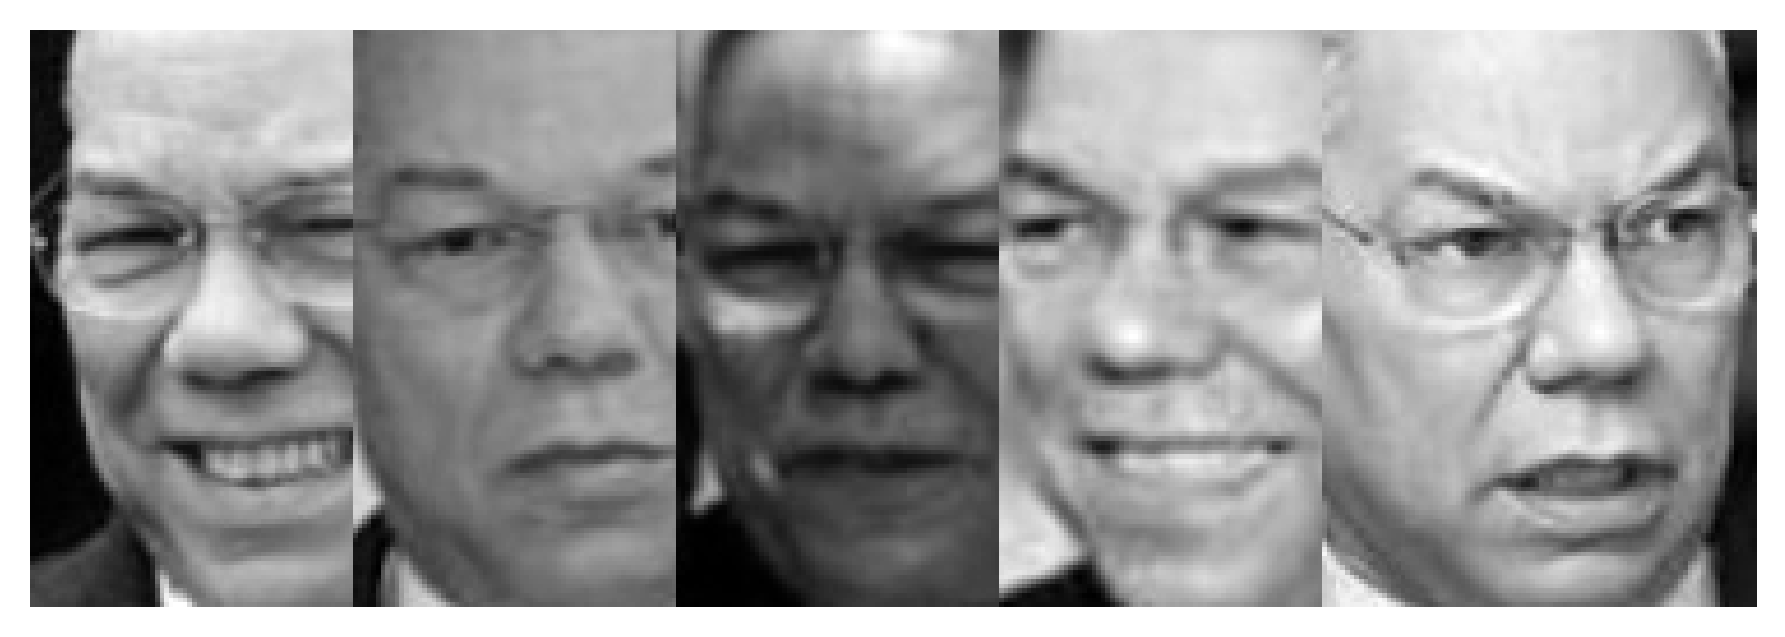

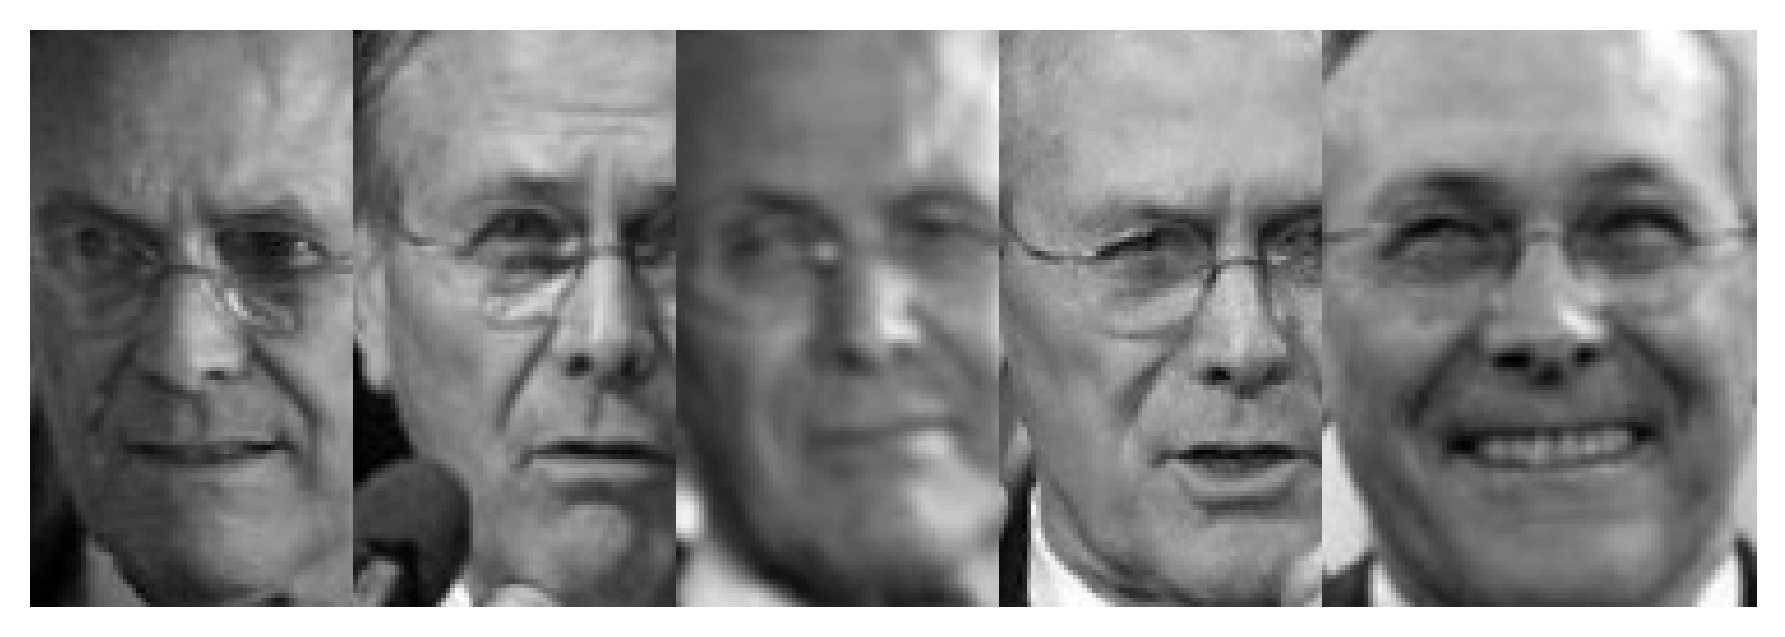

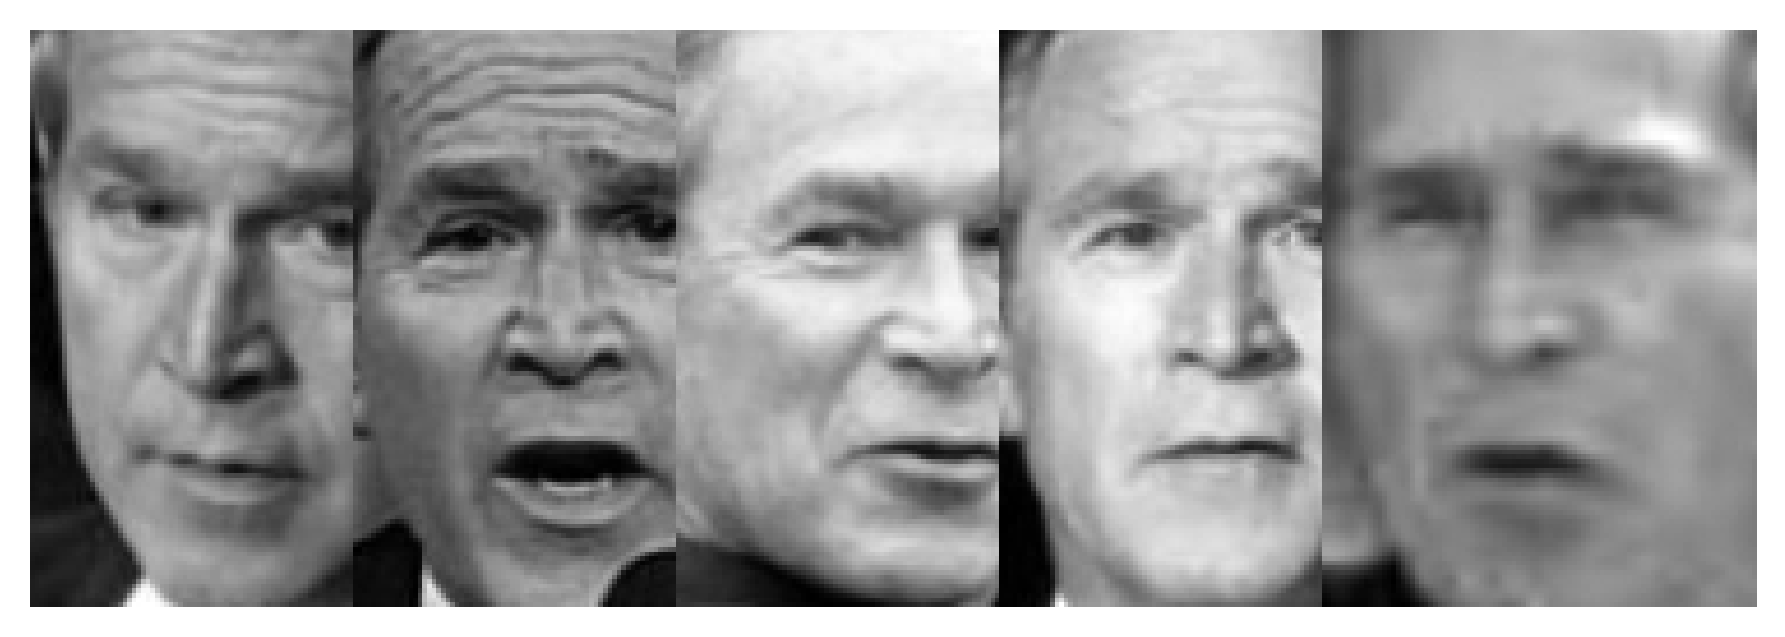

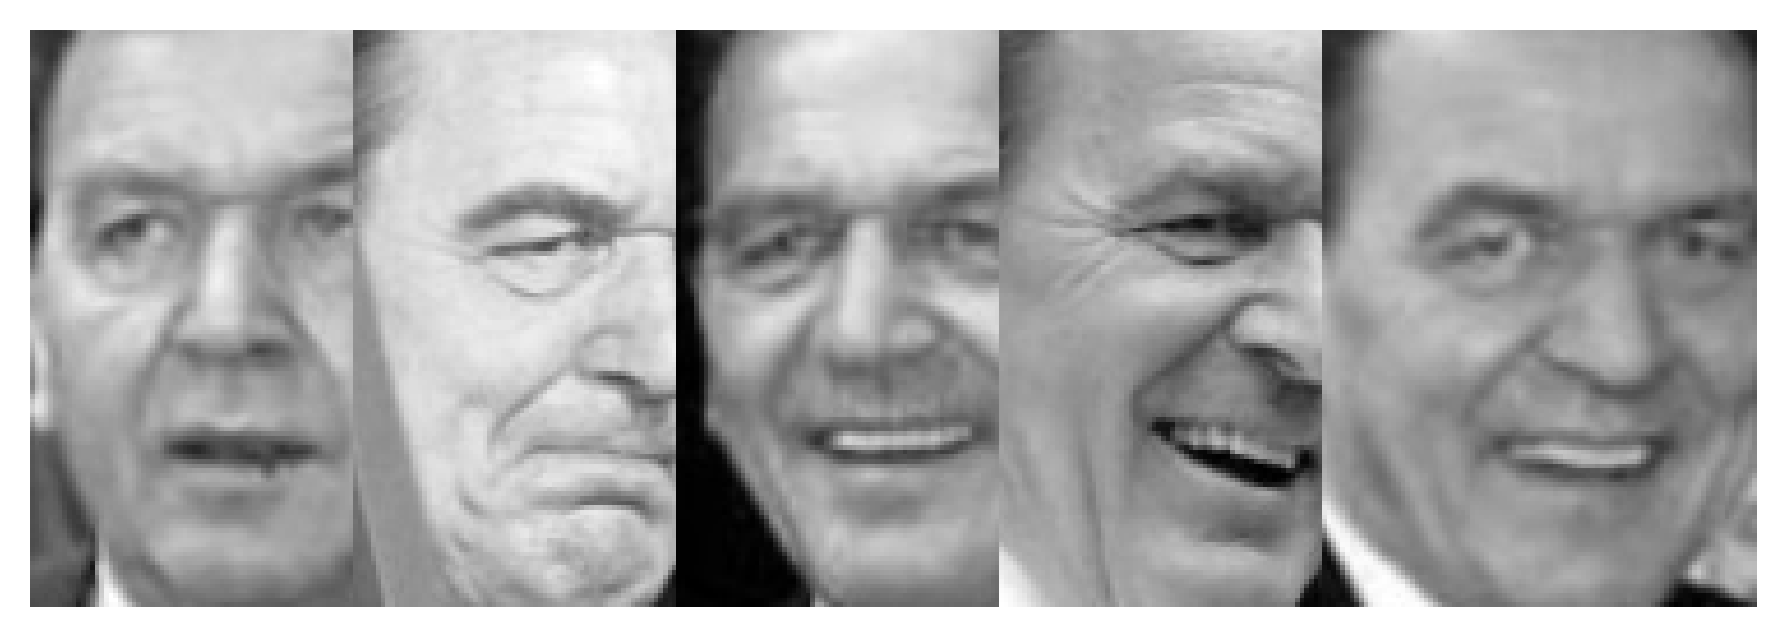

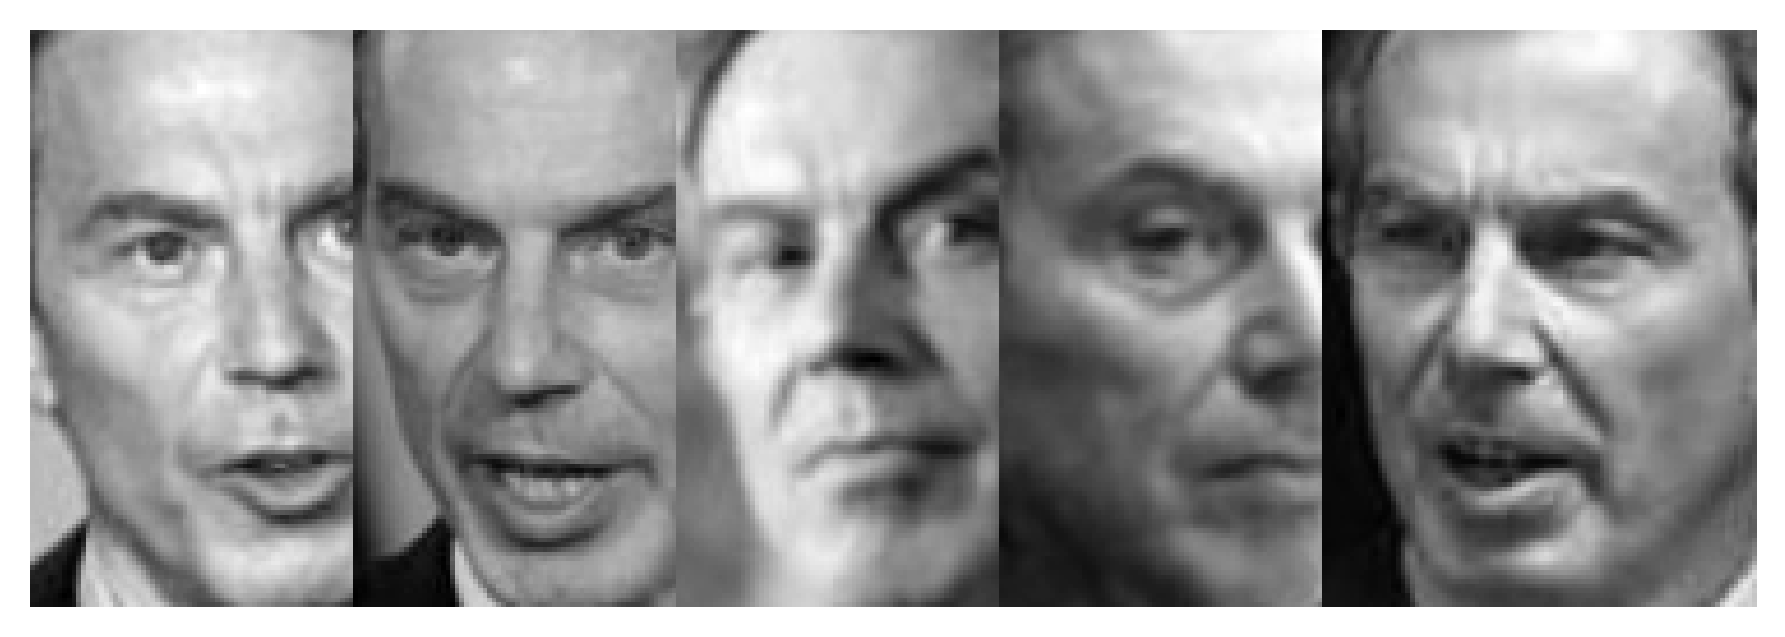

In [ ]:
n_image_per_class = 5

X_train_class_display = []

# Select first 5 image from each class as a list and add to list of images to display
for images in X_train_class:
    # TODO: Reshape vectorized image from each class to image size and store as a list
    images_display = []
    for idx in range(n_image_per_class):
      img = images[idx].reshape(n_height, n_width)
      images_display.append(img)

    X_train_class_display.append(images_display)

# TODO: Visualize the images first 5 images for each class with dpi=300 and cmap='gray'
for i in range(len(X_train_class_display)): # Corrected .size to len()
  plot_images([X_train_class_display[i]], 1, n_image_per_class, dpi=300, cmap='gray')

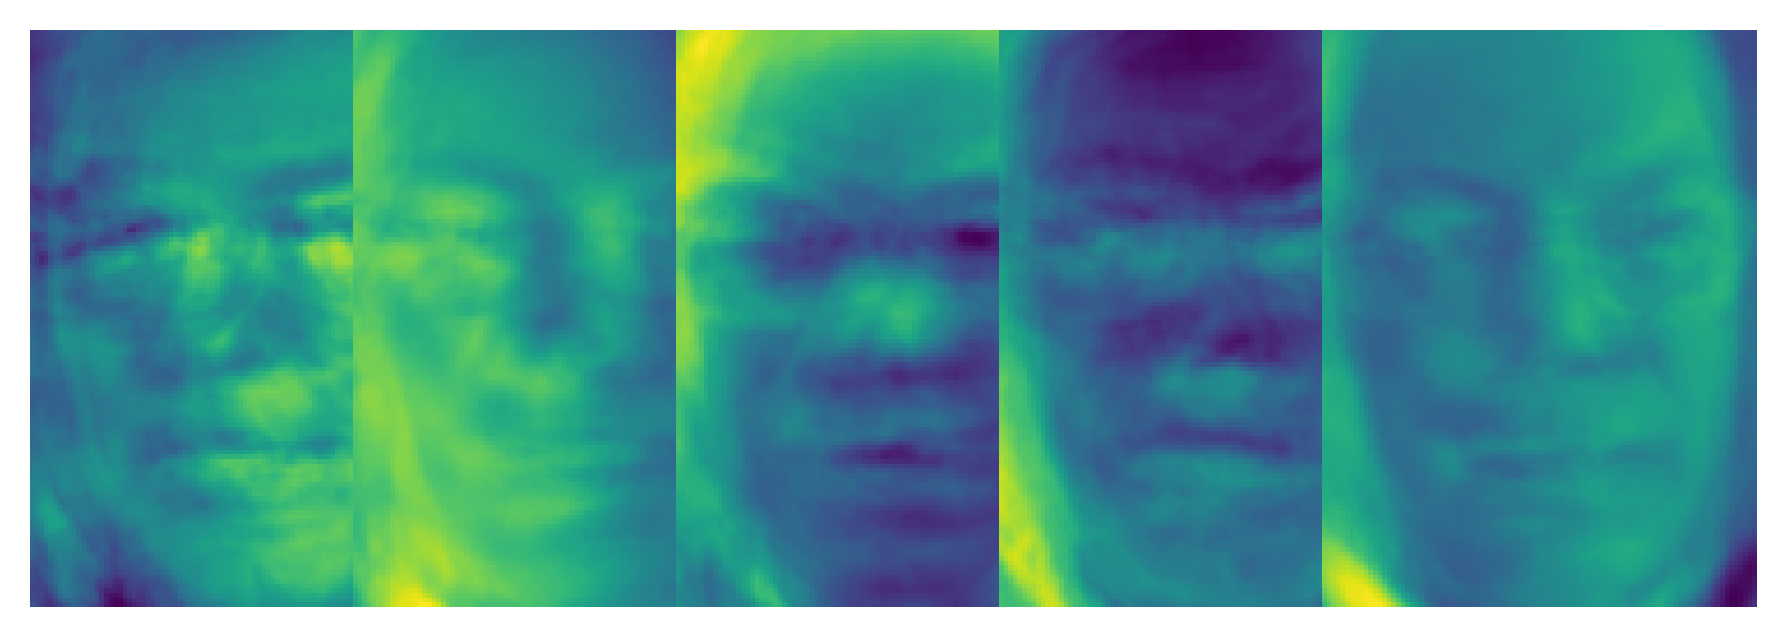

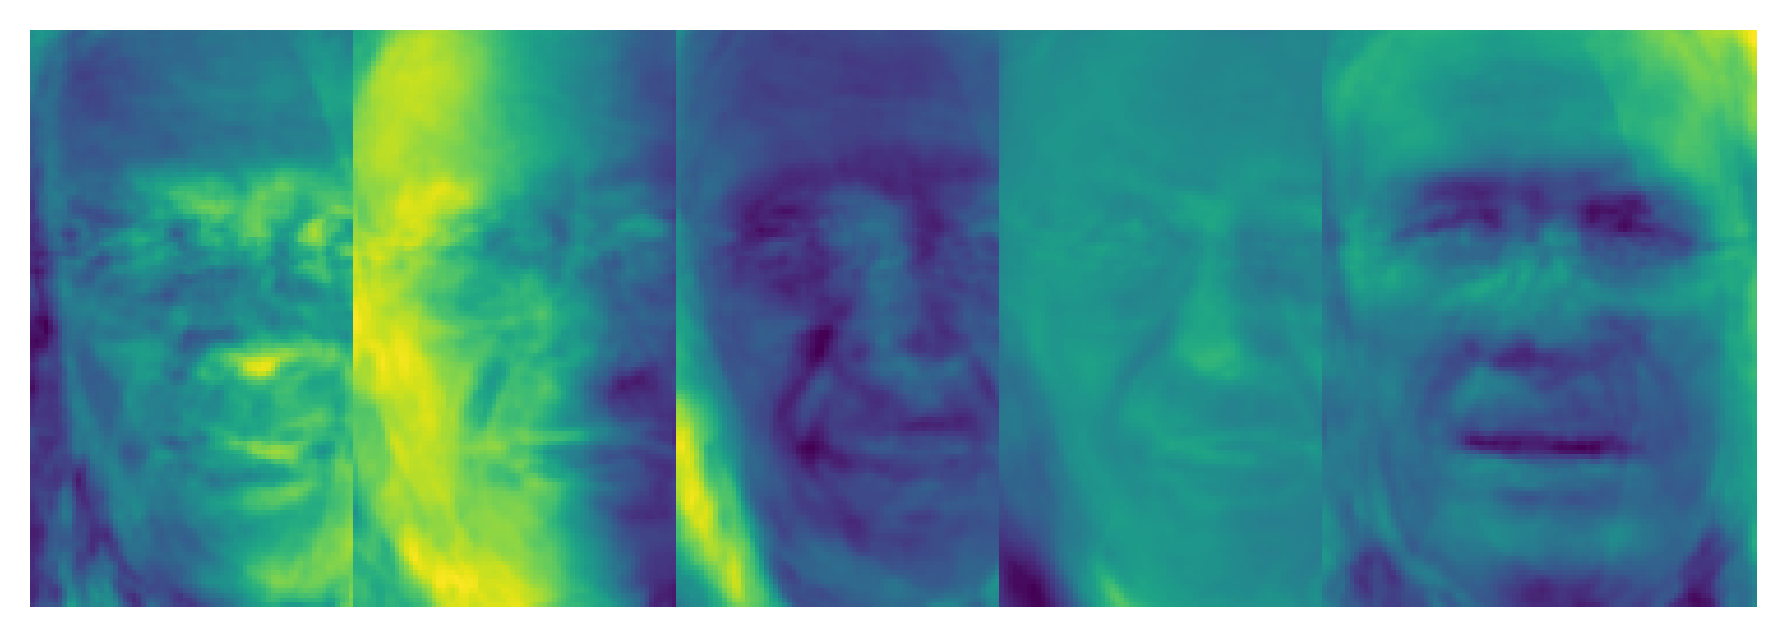

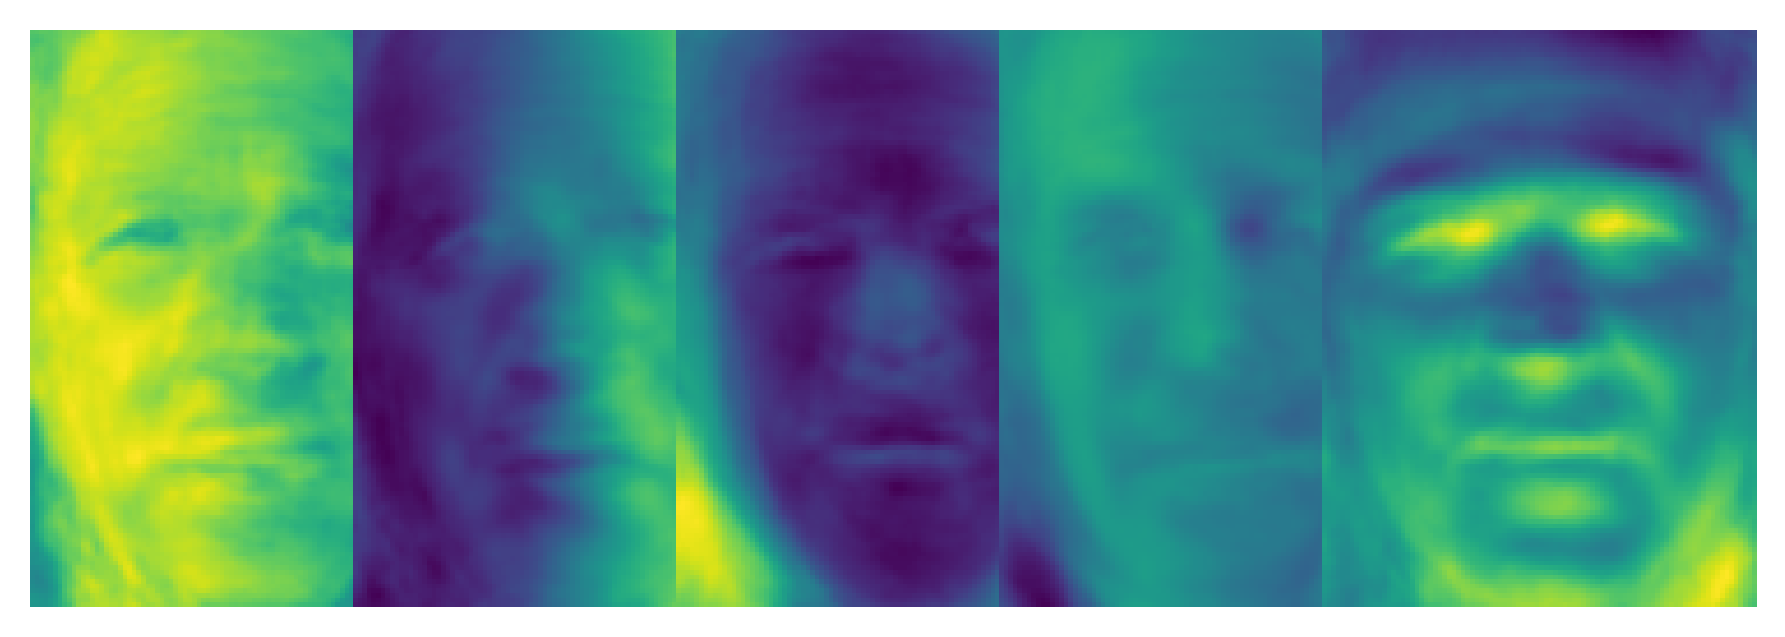

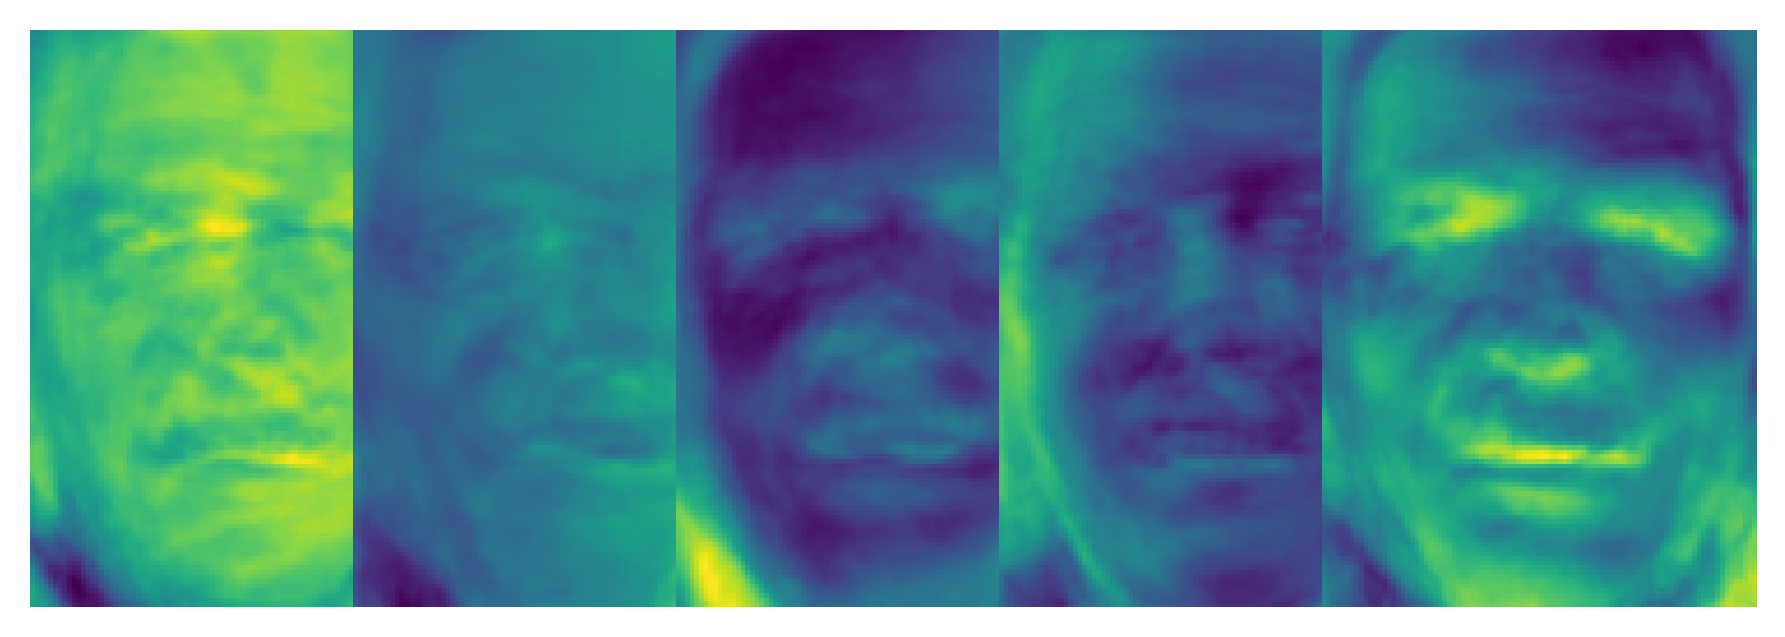

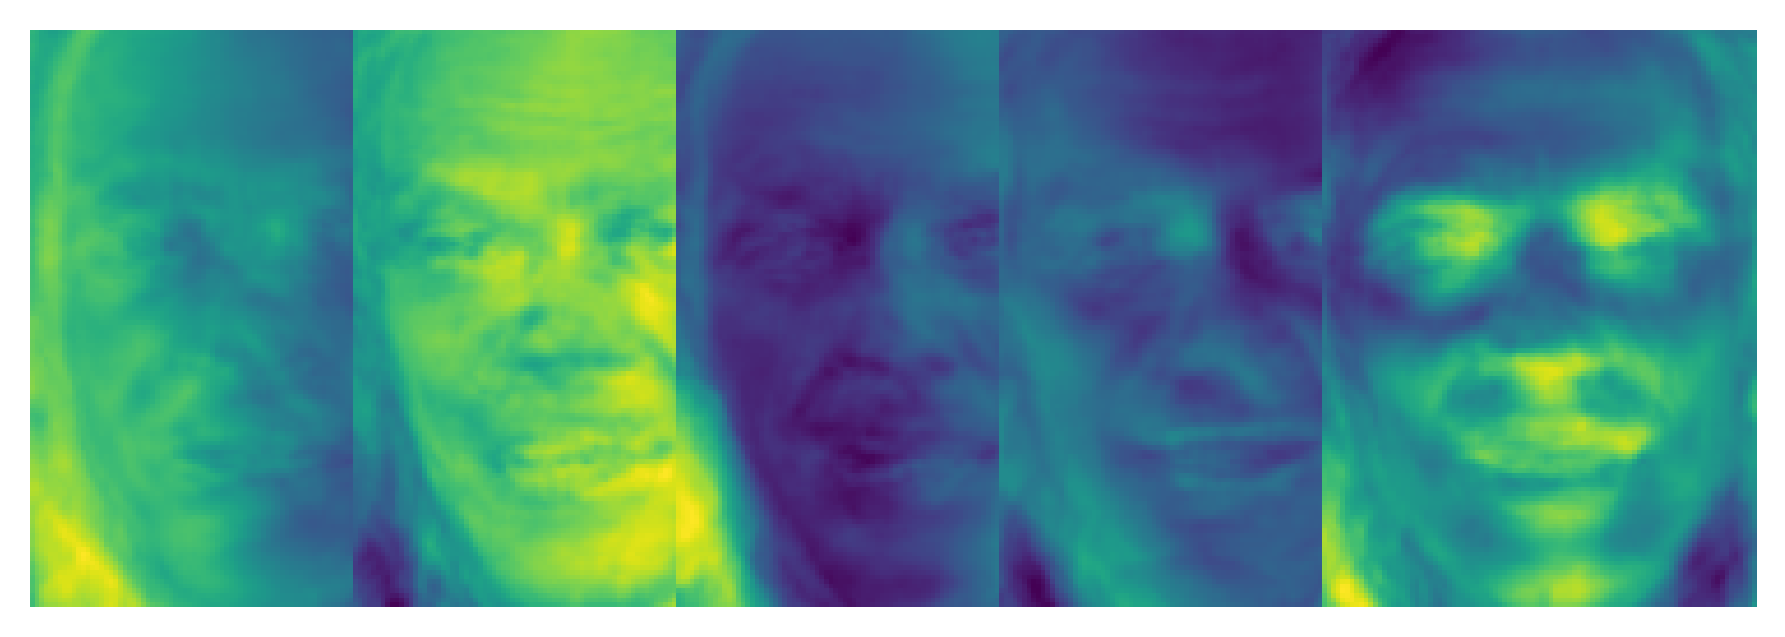

In [ ]:
eigenvectors_class_display = []

# Select first 5 principal components (eigenvectors) from each class as a list and add to list of images to display
for eigenvectors in eigenvectors_class:
    # TODO: Select first 5 eigenvectors and store as a list
    evecs_display = []
    for idx in range(n_image_per_class):
      evec = eigenvectors[idx]
      evecs_display.append(evec)
    eigenvectors_class_display.append(evecs_display)

# TODO: Visualize first 5 principal components (eigenvectors) for each class with dpi=300 and cmap=viridis
for i in range(len(eigenvectors_class_display)):
  plot_images([eigenvectors_class_display[i]], 1, n_image_per_class, dpi=300, cmap='viridis')

Inference: Project test data to eigenspace and find nearest neighbor

In [29]:
# Define storage to hold image representations and SSD scores for each individual class
Z_test_class = []
ssd_test_class_list = [] # Renamed to avoid confusion with the concatenated array

'''
Conceptual Notes:
- we're projecting test data into each class's eigenspace b/c in order to compare
  test image to set of training images, we need to represent them in same basis
  (and that is class's PCA coords)
- class-specific PCA basically tells us how well test image fits
- test images that fit well: low reconstruct. error and small NN SSD

1. PCA builds a shape of the class
2. projection asks if test image has that shape
3. nearest-neighbor compares and see's what class image test looks most like
4. argmin to find the best fit
'''

# Iterate through each class
for c in range(n_class):

    # TODO: Select KD-Tree corresponding to class
    kdtree_c = kdtrees_class[c]

    # TODO: Select PCA corresponding to class
    pca_c = pcas_class[c]

    # TODO: Project to subspace
    Z_test_c = pca_c.transform(X_test)

    # TODO: Query KNN by measuring sum squared distance to each projected point
    # with return_distance=True and sort_results=True
    # note --> query method returns distances and indices
    ssd_test_c, _ = kdtree_c.query(
        Z_test_c, k=1, return_distance=True, sort_results=True)

    # Store latent and scores to list
    Z_test_class.append(Z_test_c)
    ssd_test_class_list.append(ssd_test_c)

# TODO: Concatenate SSD scores together
# noyte: stacks the list of (N, 1) arrays into a single (N, C) array
ssd_test_class = np.hstack(ssd_test_class_list)

# TODO: Select the class with min SSD score as predicted class
y_hat_test = np.argmin(ssd_test_class, axis=1)

# TODO: Compute the mean accuracy of prediction based on test set ground truth
score = (y_hat_test == y_test).mean()

# Print mean accuracy
print('Mean accuracy over {} samples using {} latent dimensions: {}'.format(
    n_sample_test,
    n_dimension_latent,
    score))

Mean accuracy over 114 samples using 90 latent dimensions: 0.5175438596491229
